#SME0104 - Trabalho 2

## Dupla:
Miguel Prates Ferreira de Lima Cantanhede  
Ada Maris Pereira Mário

##Bibliotecas

In [ ]:
import math
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2

## Questão 1

A decomposição SVD de uma matriz $A_{m×n}$ tem a forma

\begin{equation}
A = U ΣV T
\end{equation}

em que $U$ é uma matriz $m × n$ ortogonal, $V$ uma matriz também ortogonal com dimensão $n × n$ e $Σ$ uma matriz diagonal $m × n$ com entradas

\begin{equation}
\sigma_{ij} =
  \begin{cases}
    0, & \text{para}\ i \neq j \\
    \sigma_i \geq 0 & \text{para}\ i = j
  \end{cases}
\end{equation}

Esses valores $\sigma_i$ são chamados de valores singulares de $A$ e geralmente são ordenados tais que $\sigma_{i-1} \geq \sigma_i, i = 2, \ldots, min\{m, n\}$. Já as colunas de $U$ e $V$ são os vetores singulares à esquerda e à direita, respectivamente. Esta decomposição está diretamente ligada a algoritmos para calcular autovalores e autovetores de matrizes. Os valores singulares de $A$ são as raı́zes quadradas dos autovalores de $A^TA$ e as colunas $U$ e $V$ são os autovetores ortonormais de $AA^T$ e $A^TA$ respectivamente.

Ainda, para uma matriz simétrica $B_{n×n}$, a decomposição QR pode ser usada para calcular todos os seus autovalores e autovetores usado sucessivas decomposições até que se obtenha uma matriz diagonal (ou muito próxima de uma diagonal). O processo envolvido é

1. $B_1 = B$ decompõe-se a matriz $B_1 = Q_1 R_1$
2. $B_2 = R_1 Q_1$ decompõe-se a matriz $B_2 = Q_2 R_2$
3. $B_3 = R_2 Q_2$ e então $B_3 = Q_3 R_3$
4. Repete-se essas iterações até $B_k = R_{k−1} Q_{k−1}$

como trata-se de um processo iterativo, é importante escolher um bom critério de parada. Dentre os critérios mais usados, pode-se limitar o número de iterações $k$ por um máximo de iterações $k_max$, verificar se os elementos da matriz fora da diagonal estão tão próximos de zero quanto se queira usando uma tolerância

\begin{equation}
max_{i<j} \{|b_{ij}|\} < \epsilon
\end{equation}

ou verificar se $off(B) < \epsilon$ em que

\begin{equation}
off(B) = \sqrt{\left\| B \right\|_F^2 - \sum_{i=1}^{n} b_{ii}^2}
\end{equation}

Este método é conhecido como método de Francis, ao final do processo iterativo, tem-se

\begin{equation}
B_k = V^TBV
\end{equation}

em que $V = Q_1 Q_2 \ldots Q_{k−1}$, ou seja, $B$ e $B_k$ são matrizes semelhantes e possuem os mesmos autovalores. Além disso, $B_k$, como dito anteriormente, converge para uma matriz diagonal, ou seja, os elementos da diagonal de $B_k$ fornecem uma aproximação para os autovalores de $B$ e as colunas das matriz $V = Q_1 Q_2 \ldots Q_{k−1}$ são aproximações dos respectivos autovetores. O método de Francis pode ser usado para obter a decomposição SVD de uma matriz qualquer $A_{m×n}$ ao ser aplicado nas matrizes simétricas $AA^T$ e $A^TA$, uma vez que

• $AA^T = (U ΣV^T )(U ΣV^T )^T = U Σ(V^T V )ΣU^T = U Σ^2 U^T$ e

• $A^TA = (U ΣV^T )^T (U ΣV^T ) = V Σ(U^T U )ΣV^T = V Σ^2 V^T$.


###a) Escreva um código implementando o método de Francis usando a função *numpy.linalg.qr* para obter as decomposições QR necessárias.

In [ ]:
def off(A):
  frobenius_norm = np.linalg.norm(A, 'fro') ** 2
  diag_sum = np.sum(np.diag(A) ** 2)
  return np.sqrt(frobenius_norm - diag_sum)
def metodo_de_francis(A,tol=1e-5,kmax=10000):
  if kmax is None:
    kmax=10000
  n = A.shape[0]
  V = np.eye(n)
  erro = math.inf
  k=0
  while erro > tol and k<kmax:
    Q,R = np.linalg.qr(A)
    A = R @ Q
    V = V @ Q
    erro = off(A)
    k+=1
  D = np.diag(A)
  return V,D

A = np.array([[4, 1, 2], [1, 3, 1], [2, 1, 3]], dtype=float)
print(f"Matriz:\n {A}")
tol = 1e-6
V, D = metodo_de_francis(A, tol)
print("Autovalores (diagonal de D):", D)
print("Autovetores (colunas de V):\n", V)

print("----------\nProva real: ")
A_reconstruida = V @ np.diag(D) @ np.linalg.inv(V)
print(f"Matriz obtida por VDV-1: \n{A_reconstruida}")

Matriz:
 [[4. 1. 2.]
 [1. 3. 1.]
 [2. 1. 3.]]
Autovalores (diagonal de D): [6.18194334 2.40642065 1.41163601]
Autovetores (colunas de V):
 [[-0.71178541  0.41526188 -0.56649721]
 [-0.40422217 -0.90175254 -0.15312345]
 [-0.57442663  0.1199997   0.80971237]]
----------
Prova real: 
Matriz obtida por VDV-1: 
[[4.00000033 0.99999969 1.99999981]
 [0.99999969 2.99999981 1.00000052]
 [1.99999981 1.00000052 2.99999987]]


###b) Usando a rotina implementada para o método de Francis, escreva um código que retorne a decomposição SVD de uma matriz qualquer $A_{m×n}$. *Dica: use o método de Francis apenas uma vez em $AA^T$ ou em $A^TA$ e obtenha a matriz faltante a partir da expressão da decomposição SVD de $A$.*

In [ ]:
def SVD_francis(A,tol=1e-5,max_iters=None):
  m,n = A.shape
  k = min(m,n)
  S = np.zeros((m,n))
  U, D = metodo_de_francis(A @ A.T,kmax=max_iters)
  D = np.abs(D)
  S_k = np.diag(np.sqrt(D[:k]))
  V = (A.T @ U[:, :k]) @ np.linalg.inv(S_k) ## V = (A.t @ U) @ (S-1)
  return U,S_k,V
def SVD_cut(U,S,V,k=None,p=None):
  if k is None and p is None:
    k = len(S)
  if k is None and p is not None:
    k = int(len(S) * p/100)
  return U[:,:k] @ S[:k,:k] @ V[:,:k].T

A = np.random.randint(0,10,size=(5,5))
print(f"Matriz:\n {A}\n")
tol = 1e-6


original_options = np.get_printoptions()
np.set_printoptions(precision=2, suppress=True)

U,S,V = SVD_francis(A,tol=tol)
print(f"U:\n{U}")
print(f"S:\n{S}")
print(f"V:\n{V}")
print("\n---- Prova real: \n")
A_refeita = U @ S @ V.T
print(f"refeito por SVD (total): \n{A_refeita}")

for k in [1,2,3]:
  Ak = SVD_cut(U,S,V,k)
  print(f"refeito por SVD (k={k}): \n{Ak}\n")

np.set_printoptions(**original_options)

Matriz:
 [[4 8 6 1 1]
 [5 9 1 2 3]
 [4 8 5 4 5]
 [0 2 5 6 2]
 [1 7 1 4 2]]

U:
[[ 0.48  0.14 -0.76  0.41  0.03]
 [ 0.49  0.5   0.29 -0.16 -0.64]
 [ 0.56 -0.13 -0.   -0.65  0.5 ]
 [ 0.28 -0.84  0.04  0.06 -0.45]
 [ 0.37 -0.01  0.58  0.62  0.38]]
S:
[[21.16  0.    0.    0.    0.  ]
 [ 0.    6.9   0.    0.    0.  ]
 [ 0.    0.    4.6   0.    0.  ]
 [ 0.    0.    0.    2.54  0.  ]
 [ 0.    0.    0.    0.    0.99]]
V:
[[ 0.33  0.37 -0.22 -0.45 -0.71]
 [ 0.75  0.41  0.14  0.43  0.25]
 [ 0.38 -0.51 -0.76  0.01  0.14]
 [ 0.32 -0.65  0.52  0.13 -0.43]
 [ 0.29 -0.1   0.29 -0.77  0.48]]

---- Prova real: 

refeito por SVD (total): 
[[ 4.  8.  6.  1.  1.]
 [ 5.  9.  1.  2.  3.]
 [ 4.  8.  5.  4.  5.]
 [-0.  2.  5.  6.  2.]
 [ 1.  7.  1.  4.  2.]]
refeito por SVD (k=1): 
[[3.36 7.64 3.83 3.3  2.91]
 [3.39 7.72 3.87 3.33 2.94]
 [3.93 8.95 4.48 3.87 3.41]
 [1.94 4.42 2.22 1.91 1.69]
 [2.58 5.87 2.94 2.54 2.24]]

refeito por SVD (k=2): 
[[ 3.71  8.04  3.34  2.68  2.82]
 [ 4.66  9.15  2.09  1.1   2.59]

###c) Podemos armazenar uma imagem em uma matriz $A_{m×n}$. Toda imagem consiste em um conjunto de pixels que são os blocos de construção dessa imagem. Cada pixel representa a cor ou a intensidade da luz em um local especı́fico na imagem. Em uma imagem em escala de cinza em formato PNG, cada pixel tem um valor entre $0$ e $1$, em que $0$ corresponde ao preto e $1$ corresponde ao branco. Assim, uma imagem em escala de cinza com $m × n$ pixels pode ser armazenada em uma matriz $m × n$ com valores entre $0$ e $1$. Use a função *imread()* da biblioteca Matplotlib do Python para carregar a imagem *cat.png* em escala de cinza. Depois, use as decomposições SVD *numpy.linalg.svd* e a implementada no ı́tem 2) para comprimir a imagem, representando-a por $k$ $(k < min\{m, n\})$ valores singulares, isto é, troque a matriz $A$ por $A_k = U [:, : k] ∗ Σ[: k, : k] ∗ V^T [: k, :]$. Plote a imagem original e a imagem $50%$ e $70%$ comprimida e compare os resultados. Para tal, use a função *imshow()*, também da biblioteca Matplotlib.

In [ ]:
tol = 1e-6
img = np.array(cv2.imread('cat.png',cv2.IMREAD_GRAYSCALE))
U,S,V = SVD_francis(img,tol=tol,max_iters=min(img.shape))

(324, 324)


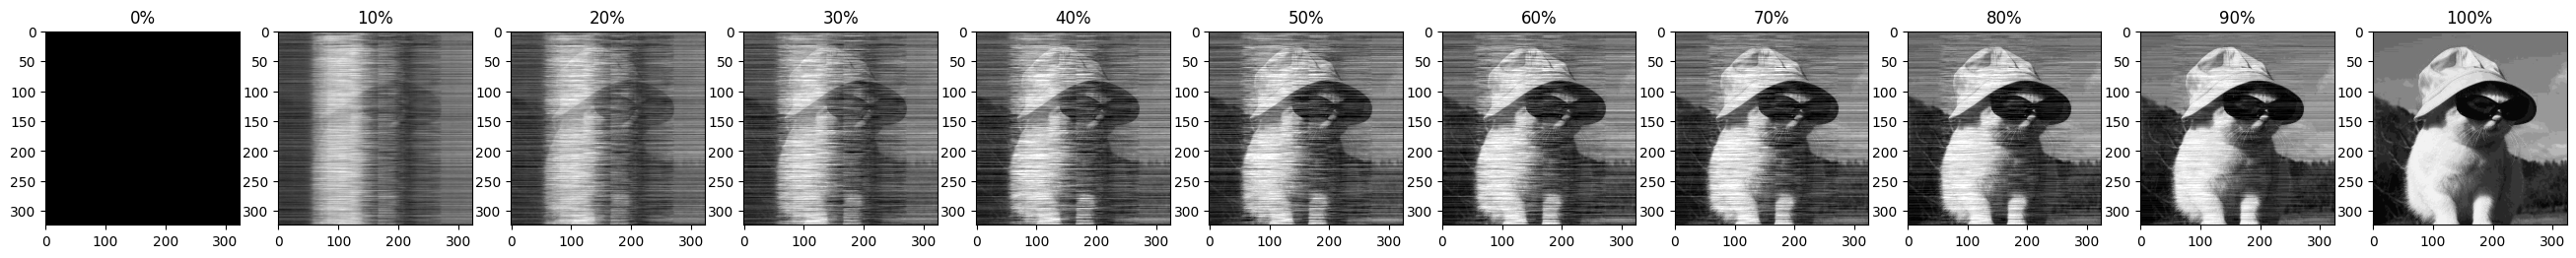

In [ ]:
import matplotlib.pyplot as plt

print(img.shape)
porcentagens = np.arange(0,101,10)
fig,axs = plt.subplots(1,len(porcentagens),figsize=(3*len(porcentagens),3))
for ax,porcentagem in list(zip(axs,porcentagens)):
  ax.set_title(f'{porcentagem}%')

  svd_img = SVD_cut(U,S,V,p=porcentagem)
  ax.imshow(svd_img,cmap='gray',vmin=0,vmax=255)
plt.show()

## Questão 2

Para a função

\begin{equation}
f (t) = \frac{1}{1 + 25t^2}
\end{equation}

no intervalo $[−1, 1]$ faça:

## Resumo teórico: Interpolação

A interpolação polinomial é uma técnica usada para encontrar um polinômio que passa exatamente por um conjunto de pontos dados. Dois métodos comuns de interpolação polinomial são a forma de Lagrange e a forma de Newton.

Dado um conjunto de pontos $(x_i, y_i)$, onde $i = 0, 1, \ldots, n$, queremos encontrar um polinômio $P(x)$ de grau $n$ tal que:
\begin{equation}
P(x_i) = y_i \quad \text{para } i = 0, 1, \ldots, n
\end{equation}

**Forma de Lagrange**

O polinômio interpolador na forma de Lagrange é dado por:
\begin{equation}
P(x) = \sum_{i=0}^{n} y_i L_i(x)
\end{equation}
em que $L_i(x)$ são os polinômios de base de Lagrange definidos por:
\begin{equation}
L_i(x) = \prod_{\substack{0 \leq j \leq n \\ j \neq i}} \frac{x - x_j}{x_i - x_j}
\end{equation}

**Forma de Newton**

O polinômio interpolador na forma de Newton usa uma representação incremental baseada em diferenças divididas. Ele é dado por:
\begin{equation}
P(x) = a_0 + a_1(x - x_0) + a_2(x - x_0)(x - x_1) + \cdots + a_n(x - x_0)(x - x_1) \cdots (x - x_{n-1})
\end{equation}
onde os coeficientes $a_i$ são determinados pelas diferenças divididas:
\begin{equation}
a_0 = y_0
\end{equation}
\begin{equation}
a_1 = \frac{y_1 - y_0}{x_1 - x_0}
\end{equation}
\begin{equation}
a_2 = \frac{\frac{y_2 - y_1}{x_2 - x_1} - \frac{y_1 - y_0}{x_1 - x_0}}{x_2 - x_0}
\end{equation}
\begin{equation}
a_i = \frac{f[x_i, x_{i-1}, \ldots, x_0] - f[x_{i-1}, x_{i-2}, \ldots, x_0]}{x_i - x_0}
\end{equation}
com $f[x_i, x_{i-1}, \ldots, x_0]$ representando a diferença dividida de ordem $i$.

A interpolação polinomial fornece uma maneira de estimar valores intermediários entre pontos de dados conhecidos. Os métodos de Lagrange e de Newton são duas abordagens diferentes para encontrar o polinômio interpolador. Enquanto a forma de Lagrange usa polinômios de base, a forma de Newton utiliza uma representação incremental baseada em diferenças divididas, oferecendo vantagens em termos de computação incremental e estabilidade numérica.


###a) Implemente as interpolações de Lagrange e de Newton.

In [ ]:
def lagrange_interp(xi,yi,x):
  n = np.size(xi)
  m = np.size(x)
  L = np.ones((n,m))
  for i in np.arange(n):
    for j in np.arange(n):
      if i!=j:
        L[i,:] = (L[i,:]*(x-xi[j])) / (xi[i]-xi[j])
  y = yi.dot(L)
  return y

In [ ]:
def newton_interp(xi,yi,x):
  n = np.size(xi);ni = np.size(x); N=np.ones((n,ni))
  D = np.zeros((n,n)); D[:,0] = yi;
  for j in np.arange(n-1):
    for i in np.arange(n-j-1):
      D[i,j+1] = (D[i+1,j] - D[i,j]) / (xi[i+j+1] - xi[i])
  for i in np.arange(1,n):
    N[i,:] = N[i-1,:] * (x-xi[i-1])
  y = D[0,:].dot(N)
  return y

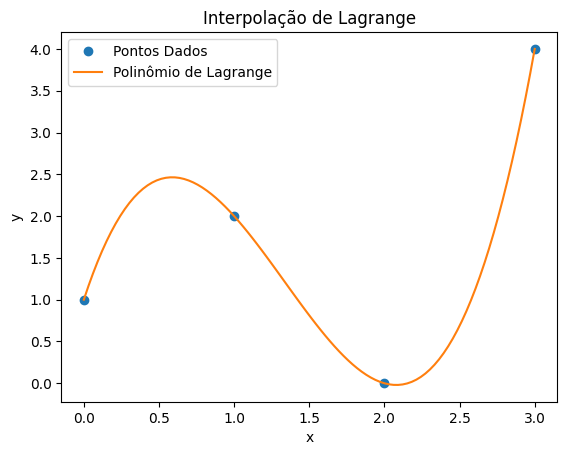

In [ ]:
# Exemplo de uso
xi = np.array([0, 1, 2, 3])
yi = np.array([1, 2, 0, 4])
x = np.linspace(0, 3, 100)  # Avaliar nos pontos entre 0 e 3

y = lagrange_interp(xi, yi, x)

plt.plot(xi, yi, 'o', label='Pontos Dados')
plt.plot(x, y, '-', label='Polinômio de Lagrange')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interpolação de Lagrange')
plt.show()


###b) Usando 11 pontos igualmente espaçados dentro do intervalo dado, calcule as interpolações de Lagrange e Newton com o código implementado no item anterior. Mostre os resultados em dois gráficos separados. Que resultado teórico justifica o fato das duas soluções serem iguais?

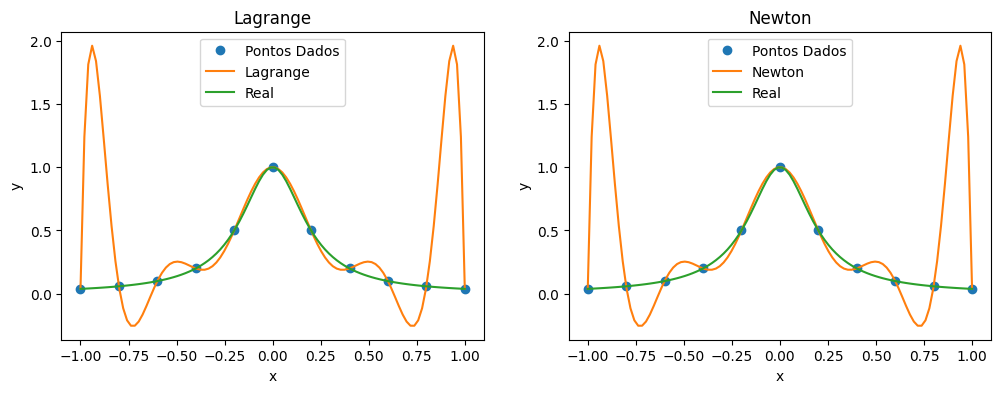

In [ ]:
f = lambda t: 1/(1+25*t**2)
intervalo = [-1,1]
n_pontos = 11

pontos_x = np.linspace(intervalo[0],intervalo[1],n_pontos)
pontos_y = np.array([f(x) for x in pontos_x])

xs = np.linspace(intervalo[0],intervalo[1],100)

y_lagrange = lagrange_interp(pontos_x, pontos_y, xs)
y_newton = newton_interp(pontos_x, pontos_y, xs)
y_real = [f(x) for x in xs]

fig,axs = plt.subplots(1,2,figsize=(6*2,4))

ax = axs[0]
ax.plot(pontos_x, pontos_y, 'o', label='Pontos Dados')
ax.plot(xs, y_lagrange, '-', label='Lagrange')
ax.plot(xs,y_real,'-', label='Real')
ax.set_title("Lagrange")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

ax = axs[1]
ax.plot(pontos_x, pontos_y, 'o', label='Pontos Dados')
ax.plot(xs, y_newton, '-', label='Newton')
ax.plot(xs,y_real,'-', label='Real')
ax.set_title("Newton")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

# plt.title(f'interpolações com {n_pontos}')
plt.show()

In [ ]:
# Bom, o resumo teórico se encontra acima e, o embasamento é que os dois métodos no fim chegam
# literalmente no mesmo polinômio, embora o método pra se chegar neles seja diferente

###c) Repita o processo com 21 pontos. O que acontece? Exiba o gráfico das soluções comparando com a exata.

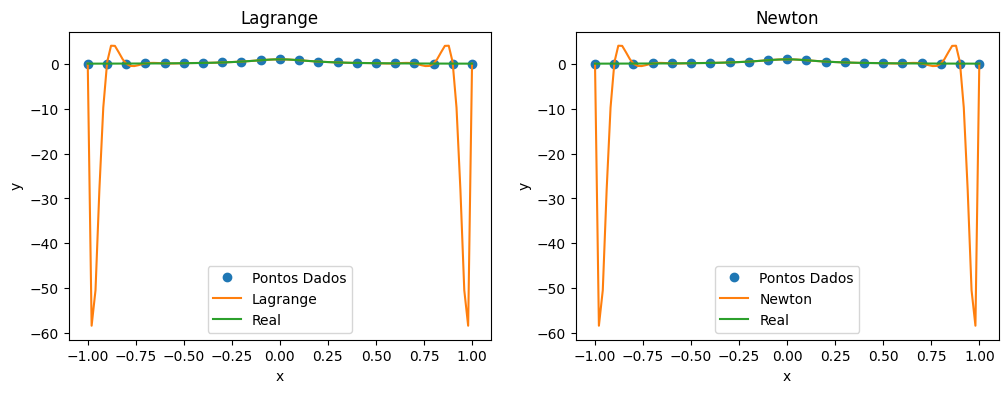

In [ ]:
f = lambda t: 1/(1+25*t**2)
intervalo = [-1,1]
n_pontos = 21

pontos_x = np.linspace(intervalo[0],intervalo[1],n_pontos)
pontos_y = np.array([f(x) for x in pontos_x])

xs = np.linspace(intervalo[0],intervalo[1],100)

y_lagrange = lagrange_interp(pontos_x, pontos_y, xs)
y_newton = newton_interp(pontos_x, pontos_y, xs)
y_real = [f(x) for x in xs]


fig,axs = plt.subplots(1,2,figsize=(6*2,4))

ax = axs[0]
ax.plot(pontos_x, pontos_y, 'o', label='Pontos Dados')
ax.plot(xs, y_lagrange, '-', label='Lagrange')
ax.plot(xs,y_real,'-', label='Real')
ax.legend()
ax.set_title("Lagrange")
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = axs[1]
ax.plot(pontos_x, pontos_y, 'o', label='Pontos Dados')
ax.plot(xs, y_newton, '-', label='Newton')
ax.plot(xs,y_real,'-', label='Real')
ax.legend()
ax.set_title("Newton")
ax.set_xlabel('x')
ax.set_ylabel('y')


# plt.title(f'interpolações com {n_pontos}')
plt.show()

In [ ]:
# parece que está acontecendo um overfitting na função, justamente o que é previsto pelo fenômeno de Runge.
# Explicando bem por cima:
# quando se coloca poucos pontos, o polinômio interpolador vai ter um grau baixo. Com um número maior de pontos,
# vai aumentar o grau do polinômio também. Isso acontece pq não é garantia que a interpolação
# consegue minimizar o erro nesse intervalo e, nesse caso, conforme n->inf, o erro de -1 a 1 tende a inf também

###d) Usando a função **scipy.interpolate.interp1d** calcule a interpolação usando spline linear e cúbica, considerando 21 pontos igualmente espaçados. Exiba os gráficos e comente as diferenças das soluções deste item para os anteriores.

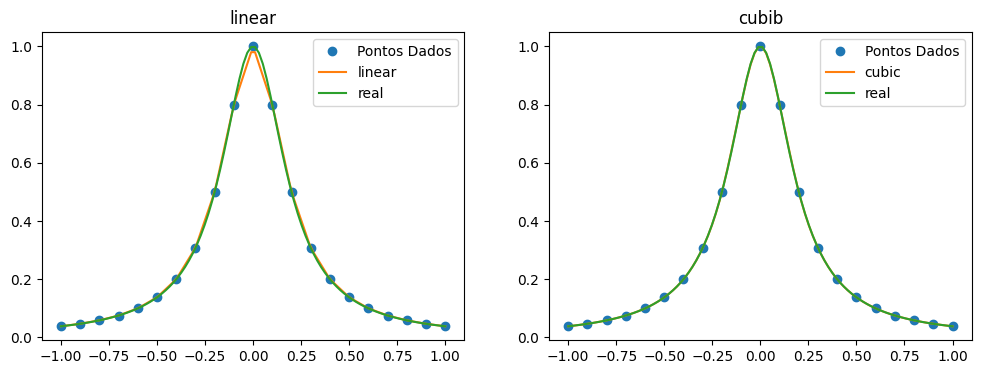

In [ ]:
import scipy
f = lambda t: 1/(1+25*t**2)
intervalo = [-1,1]
n_pontos = 21

pontos_x = np.linspace(intervalo[0],intervalo[1],n_pontos)
pontos_y = np.array([f(x) for x in pontos_x])

f_linear = scipy.interpolate.interp1d(pontos_x,pontos_y,kind='linear')
f_cubic  = scipy.interpolate.interp1d(pontos_x,pontos_y,kind='cubic')

xs = np.linspace(intervalo[0],intervalo[1],100)
ys_linear = [f_linear(x) for x in xs]
ys_cubic = [f_cubic(x) for x in xs]
ys_real = [f(x) for x in xs]



fig,axs = plt.subplots(1,2,figsize=(6*2,4))

ax = axs[0]

ax.plot(pontos_x,pontos_y,'o',label='Pontos Dados')
ax.plot(xs,ys_linear,label='linear')
ax.plot(xs,ys_real,label='real')
ax.set_title("linear")
ax.legend()

ax = axs[1]
ax.plot(pontos_x,pontos_y,'o',label='Pontos Dados')
ax.plot(xs,ys_cubic,label='cubic')
ax.plot(xs,ys_real,label='real')
ax.set_title("cubib")
ax.legend()

# plt.title("Métodos do Scipy")
plt.show()

In [ ]:
# Ok, aqui parece que o overfitting não acontece mais em comparação com os outros experimentos, embora que
# a função linear ainda não seja a ideal pelo fato da função que estamos lidando não possuir esse comportamento

###e) Repita os itens b) e c) com nós de Chebyshev. Comente os resultados obtidos. Por que este resultado é melhor do que os resultados obtidos nos ı́tens b) e c)?

In [ ]:
import math
def nos_chebyshev(a,b,n):
  xs = []
  c = (a+b)/2
  d = (b-a)/2
  for i in range(n):
    xi = c + d * math.cos((2*i+1)*math.pi / (2*(n+1)))
    xs.append(xi)
  return xs

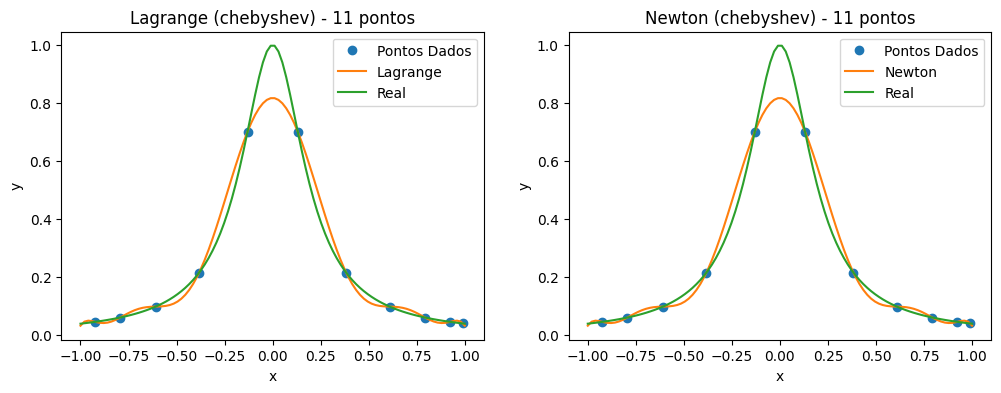

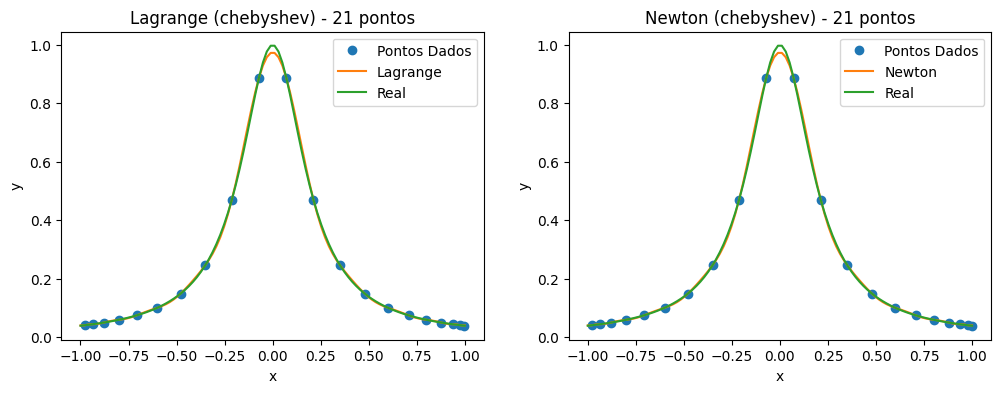

In [ ]:
## e)
f = lambda t: 1/(1+25*t**2)
intervalo = [-1,1]
n_pontos = 11

pontos_x = nos_chebyshev(intervalo[0],intervalo[1],n_pontos)
pontos_y = np.array([f(x) for x in pontos_x])

xs = np.linspace(intervalo[0],intervalo[1],100)

y_lagrange = lagrange_interp(pontos_x, pontos_y, xs)
y_newton = newton_interp(pontos_x, pontos_y, xs)
y_real = [f(x) for x in xs]


fig,axs = plt.subplots(1,2,figsize=(6*2,4))
ax = axs[0]
ax.plot(pontos_x, pontos_y, 'o', label='Pontos Dados')
ax.plot(xs, y_lagrange, '-', label='Lagrange')
ax.plot(xs,y_real,'-', label='Real')
ax.set_title(f"Lagrange (chebyshev) - {n_pontos} pontos")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

ax = axs[1]
ax.plot(pontos_x, pontos_y, 'o', label='Pontos Dados')
ax.plot(xs, y_newton, '-', label='Newton')
ax.plot(xs,y_real,'-', label='Real')
ax.set_title(f"Newton (chebyshev) - {n_pontos} pontos")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

## ---------------- 21 pontos --------------------
n_pontos = 21

pontos_x = nos_chebyshev(intervalo[0],intervalo[1],n_pontos)
pontos_y = np.array([f(x) for x in pontos_x])

y_lagrange = lagrange_interp(pontos_x, pontos_y, xs)
y_newton = newton_interp(pontos_x, pontos_y, xs)
y_real = [f(x) for x in xs]

fig,axs = plt.subplots(1,2,figsize=(6*2,4))
ax = axs[0]
ax.plot(pontos_x, pontos_y, 'o', label='Pontos Dados')
ax.plot(xs, y_lagrange, '-', label='Lagrange')
ax.plot(xs,y_real,'-', label='Real')
ax.set_title(f"Lagrange (chebyshev) - {n_pontos} pontos")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

ax = axs[1]
ax.plot(pontos_x, pontos_y, 'o', label='Pontos Dados')
ax.plot(xs, y_newton, '-', label='Newton')
ax.plot(xs,y_real,'-', label='Real')
ax.set_title(f"Newton (chebyshev) - {n_pontos} pontos")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

In [ ]:
# Os nós de Chebyshev conseguem minimizar o erro da aproximação da função real com a interpolação.
# Esse erro (vindo do Teorema de Lagrange), em dado momento, se dá com um produtório que acaba sendo
# a parte crítica que faz a função explodir quando se tem muitos nós. Então, é feita uma minimização
# pra tentar corrigir justamente essa parte, e aí que se dá a fórmula dos nós de Chebyshev

## Questão 3

Vamos supor que os casos acumulados de Covid-19, no perı́odo inicial da pandemia, de 26 de fevereiro de 2020 a 18 de junho de 2020 são dados em *casosacumuladosbrasilatuaizado.txt*. O objetivo deste exercı́cio é estudar o ajuste dos dados, no sentido dos mı́nimos quadrados, a uma função $g(x) = ab^x$ , com $a, b \in \mathbb{R}$. Vamos utilizar os códigos implementados em aula:

### Resumo teórico: Mínimos quadrados

O método dos mínimos quadrados é uma técnica amplamente utilizada para ajustar um modelo matemático a um conjunto de dados observados, minimizando a soma dos quadrados dos erros (resíduos) entre os valores observados e os valores preditos pelo modelo.

**Modelo Polinomial**

Dado um conjunto de dados $(x_i, y_i)$, onde $i = 1, 2, \ldots, n$, queremos ajustar um polinômio de grau $k-1$ da forma
\begin{equation}
y = a_{k-1}x^{k-1} + a_{k-2}x^{k-2} + \cdots + a_1x + a_0
\end{equation}

**Formulação Matricial**

Podemos expressar o problema de ajuste como um sistema de equações lineares usando a matriz de Vandermonde $\mathbf{X}$:
\begin{equation}
\mathbf{X} = \begin{bmatrix}
x_1^{k-1} & x_1^{k-2} & \cdots & x_1 & 1 \\
x_2^{k-1} & x_2^{k-2} & \cdots & x_2 & 1 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
x_n^{k-1} & x_n^{k-2} & \cdots & x_n & 1
\end{bmatrix}
\end{equation}

O vetor de coeficientes $\mathbf{a}$ e o vetor de observações $\mathbf{y}$ são dados por
\begin{equation}
\mathbf{a} = \begin{bmatrix}
a_{k-1} \\
a_{k-2} \\
\vdots \\
a_1 \\
a_0
\end{bmatrix}
\quad \mathbf{y} = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}
\end{equation}

O problema de mínimos quadrados busca minimizar a norma dos resíduos $\mathbf{r}$:
\begin{equation}
\mathbf{r} = \mathbf{y} - \mathbf{X} \mathbf{a}
\end{equation}

**Solução via Equações Normais**

A solução do problema dos mínimos quadrados pode ser obtida resolvendo o sistema de equações normais:
\begin{equation}
\mathbf{X}^T \mathbf{X} \mathbf{a} = \mathbf{X}^T \mathbf{y}
\end{equation}

A matriz $\mathbf{A}$ e o vetor $\mathbf{b}$ são definidos como:
\begin{equation}
\mathbf{A} = \mathbf{X}^T \mathbf{X}, \quad \mathbf{b} = \mathbf{X}^T \mathbf{y}
\end{equation}

A solução $\mathbf{a}$ é então obtida resolvendo o sistema linear:
\begin{equation}
\mathbf{A} \mathbf{a} = \mathbf{b}
\end{equation}

**Solução via Decomposição QR**

Outra abordagem para resolver o problema dos mínimos quadrados é utilizar a decomposição QR da matriz $\mathbf{X}$:
\begin{equation}
\mathbf{X} = \mathbf{Q} \mathbf{R}
\end{equation}

Onde $\mathbf{Q}$ é uma matriz ortogonal e $\mathbf{R}$ é uma matriz triangular superior. O problema se simplifica para:
\begin{equation}
\mathbf{R} \mathbf{a} = \mathbf{Q}^T \mathbf{y}
\end{equation}

In [ ]:
import numpy as np

def mmq(x, y, k):
  X = np.vander(x, k)
  A = np.transpose(X).dot(X)
  b = np.transpose(X).dot(y)
  a = np.linalg.solve(A, b)
  return a

def mmq_QR(x, y, k):
  X = np.vander(x, k)
  (Q, R) = np.linalg.qr(X)
  b = np.transpose(Q).dot(y)
  a = np.linalg.solve(R, b)
  return a

###a) Explique cada um dos códigos dados acima. O que está sendo calculado?

Abaixo estão os mesmo códigos comentados para melhor compreensão:

In [ ]:
def mmq(x, y, k):
    # Cria a matriz de Vandermonde a partir do vetor x
    # A matriz terá k colunas, em que cada coluna é x
    # elevado a uma potência decrescente
    X = np.vander(x, k)

    # Calcula a matriz A = X^T X, em que X^T é a transposta de X
    A = np.transpose(X).dot(X)

    # Calcula o vetor b = X^T y
    b = np.transpose(X).dot(y)

    # Resolve o sistema linear A a = b para encontrar o vetor a dos coeficientes
    a = np.linalg.solve(A, b)

    # Retorna o vetor a dos coeficientes do polinômio ajustado
    return a


In [ ]:
def mmq_QR(x, y, k):
    # Cria a matriz de Vandermonde a partir do vetor x
    # A matriz terá k colunas, em que cada coluna é x
    # elevado a uma potência decrescente
    X = np.vander(x, k)

    # Realiza a decomposição QR da matriz X
    # Q é uma matriz ortogonal e R é uma matriz triangular superior
    (Q, R) = np.linalg.qr(X)

    # Calcula o vetor b = Q^T y
    b = np.transpose(Q).dot(y)

    # Resolve o sistema linear R a = b para encontrar o vetor a dos coeficientes
    a = np.linalg.solve(R, b)

    # Retorna o vetor a dos coeficientes do polinômio ajustado
    return a


Ambos os códigos calculam os coeficientes $a$ e $b$ de um polinômio de grau $k−1$ que melhor se ajusta a um conjunto de dados $(x,y)$ no sentido dos mínimos quadrados. A diferença entre os dois métodos está na forma de resolver o sistema de equações: enquanto o primeiro usa as equações normais dos mínimos quadrados, $a=(X^TX)^{−1}X^Ty$, resolvendo diretamente o sistema linear, o segundo usa a decomposição QR para resolver o sistema linear de uma forma numericamente mais estável, especialmente útil quando $X$ tem colunas quase lineares.

###b) Aproxime, no sentido dos mı́nimos quadrados, os dados do perı́odo completo, de 26 de fevereiro de 2020 a 18 de junho de 2020, por uma função $g(x) = ab^x$ , com $a, b \in \mathbb{R}$. Use um dos códigos dados acima.

In [ ]:
# Dados
data = np.loadtxt('/content/casosacumuladosbrasilatuaizado.txt')

In [ ]:
# Extraindo os valores de x (dias) e y (casos acumulados)
x = np.arange(len(data))
y = data

# Aplicando a transformação logarítmica
y_log = np.log(y)

# Ajustar os dados transformados usando uma regressão linear (polinômio de grau 1)
a_log = mmq(x, y_log, 2)  # Grau 2 porque inclui o termo linear e o intercepto

# Recuperar os parâmetros originais a e b
ln_a = a_log[1]
ln_b = a_log[0]

a = np.exp(ln_a)
b = np.exp(ln_b)

print(f"a = {a}, b = {b}")


a = 35.31304154317289, b = 1.1113520177397234


###c) Repita o item b) usando apenas os 20 primeiros dias.

In [ ]:
# Selecionar os primeiros 20 dias
x_primeiros = np.arange(1,21)
y_primeiros = data[:20]

# Aplicando a transformação logarítmica
y_log = np.log(y_primeiros)

# Ajustar os dados transformados usando uma regressão linear (polinômio de grau 1)
a_log = mmq(x_primeiros, y_log, 2)  # Grau 2 porque inclui o termo linear e o intercepto

# Recuperar os parâmetros originais a e b
ln_a = a_log[1]
ln_b = a_log[0]

a_primeiros = np.exp(ln_a)
b_primeiros = np.exp(ln_b)

print(f"a = {a_primeiros}, b = {b_primeiros}")

a = 0.4348862578863418, b = 1.3717182549417712


###d) Repita o item b) usando apenas os 50 últimos dias.

In [ ]:
# Selecionar os últimos 50 dias
x_ultimos = np.arange(69, 119)
y_ultimos = data[68:118]

# Aplicando a transformação logarítmica
y_log = np.log(y_ultimos)

# Ajustar os dados transformados usando uma regressão linear (polinômio de grau 1)
a_log = mmq(x_ultimos, y_log, 2)  # Grau 2 porque inclui o termo linear e o intercepto

# Recuperar os parâmetros originais a e b
ln_a = a_log[1]
ln_b = a_log[0]

a_ultimos = np.exp(ln_a)
b_ultimos = np.exp(ln_b)

print(f"a = {a_ultimos}, b = {b_ultimos}")

a = 4793.522372780089, b = 1.048790874325264


###e) Compare os itens b), c) e d). Que tipo de informação os dados nos fornecem?

In [ ]:
def g(x, a, b):
  return a * b**x

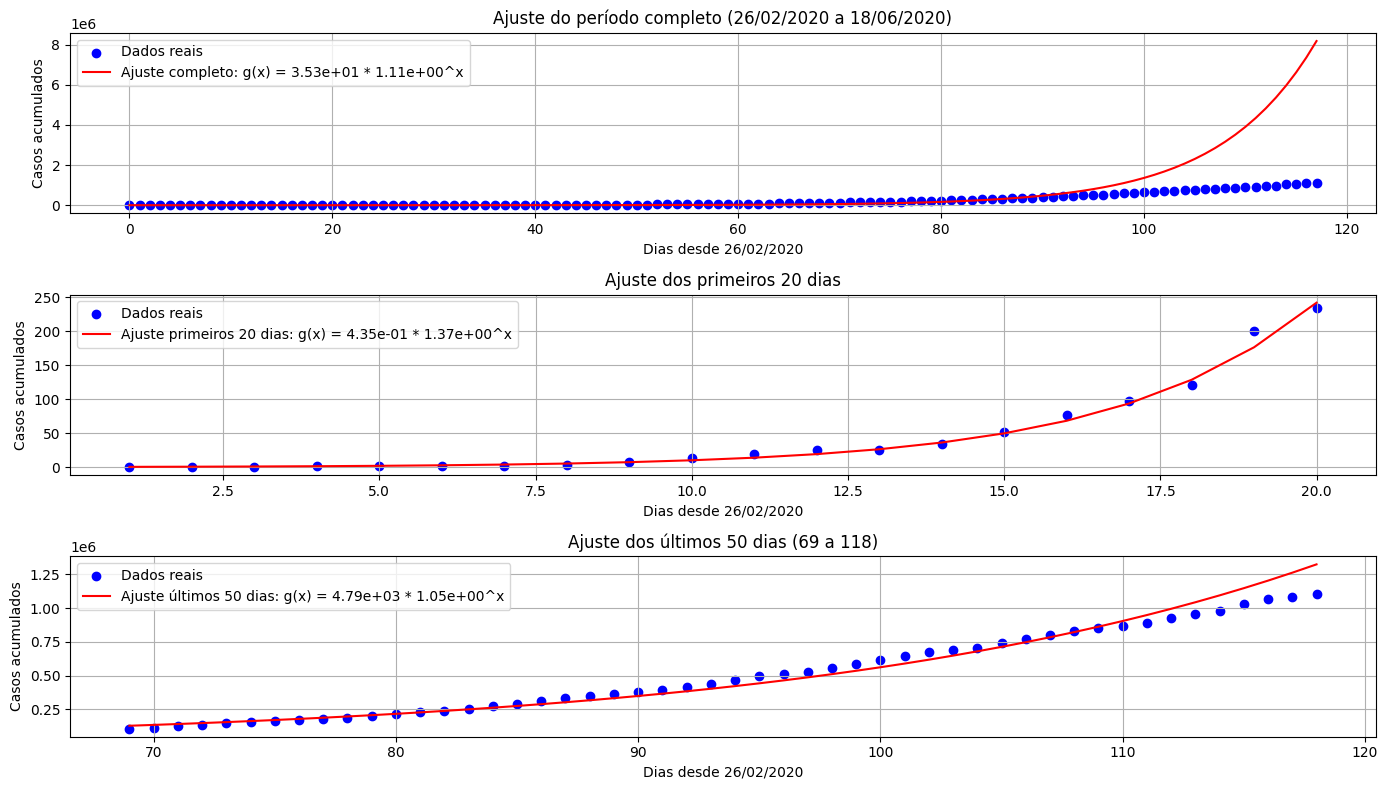

In [ ]:
plt.figure(figsize=(14, 8))

# Gráfico para o período completo
plt.subplot(3, 1, 1)
plt.scatter(x, y, label='Dados reais', color='blue')
plt.plot(x, g(x, a, b), label=f'Ajuste completo: g(x) = {a:.2e} * {b:.2e}^x', color='red')
plt.title('Ajuste do período completo (26/02/2020 a 18/06/2020)')
plt.xlabel('Dias desde 26/02/2020')
plt.ylabel('Casos acumulados')
plt.legend()
plt.grid(True)

# Gráfico para os primeiros 20 dias
plt.subplot(3, 1, 2)
plt.scatter(x_primeiros, y_primeiros, label='Dados reais', color='blue')
plt.plot(x_primeiros, g(x_primeiros, a_primeiros, b_primeiros), label=f'Ajuste primeiros 20 dias: g(x) = {a_primeiros:.2e} * {b_primeiros:.2e}^x', color='red')
plt.title('Ajuste dos primeiros 20 dias')
plt.xlabel('Dias desde 26/02/2020')
plt.ylabel('Casos acumulados')
plt.legend()
plt.grid(True)

# Gráfico para os últimos 50 dias (69 a 118)
plt.subplot(3, 1, 3)
plt.scatter(x_ultimos, y_ultimos, label='Dados reais', color='blue')
plt.plot(x_ultimos, g(x_ultimos, a_ultimos, b_ultimos), label=f'Ajuste últimos 50 dias: g(x) = {a_ultimos:.2e} * {b_ultimos:.2e}^x', color='red')
plt.title('Ajuste dos últimos 50 dias (69 a 118)')
plt.xlabel('Dias desde 26/02/2020')
plt.ylabel('Casos acumulados')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Observando os ajustes e gráficos das funções para cada período, podemos analisar o tipo de informação que os dados nos fornecem:


**Ajuste dos dados completos $\mathbf{g(x) = 35,3*1,11^x}$:** Este ajuste sugere que o número total de casos estava crescendo a uma taxa constante de $11%$ ao dia durante todo o período. O coeficiente $35,3$ sugere o número de casos iniciais

**Ajuste dos primeiros 20 dias $\mathbf{g(x) = 43,5*1,37^x}$:** Este ajuste indica que o número de casos estava crescendo a uma taxa significativamente mais alta ($37%$ ao dia) durante os primeiros 20 dias. Isso pode ser devido à rápida propagação do vírus, característico do início da pandemia, e com casos aumentando exponencialmente. O coeficiente $43,5$ sugere o número de casos iniciais, um pouco mais alto que no ajuste completo.

**Ajuste dos últimos 50 dias $\mathbf{g(x) = 4793,5*1,05^x}$:** Este ajuste mostra que a taxa de crescimento diminuiu para 5% ao dia nos últimos 50 dias. Isso pode ser um sinal de que as medidas de controle estão começando a ter efeito, ou que uma grande parte da população já foi infectada. O coeficiente $4793,5$ sugere um número inicial de casos muito maior.

Sumariamente, esses ajustes nos fornecem informações sobre como a taxa de crescimento da Covid-19 mudou ao longo do tempo. Eles podem nos ajudar a entender a eficácia das medidas de controle e a prever o futuro comportamento da pandemia.